In this project, I am building a recommendation system for <a href="https://www.gutenberg.org/">Project Gutenberg</a>'s 100 most downloaded titles. The plan is to scrape the webpages, analyze the contents, download and analyze the texts, and create a recommendation function.  
***

We'll need a few libraries. I'll import some now.

In [1]:
# Import libararies for web scraping
import requests
from bs4 import BeautifulSoup

# Import pandas and matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt

# Import time and random
import time
import random

Now we'll make a <code>GET request</code> to access https://www.gutenberg.org/ebooks/search/?sort_order=downloads where we can find the top 25 downloaded books

In [2]:
# Get the website with top 25 titles
r = requests.get('https://www.gutenberg.org/ebooks/search/?sort_order=downloads')

# Set webpage encoding
r.encoding = 'utf-8'

# Extract HTML from the request object
html = r.text

# Check the returned HTML
print(html[4809:5247])

<li class="booklink">
<a class="link" href="/ebooks/84" accesskey="4">
<span class="cell leftcell with-cover">
<img class="cover-thumb" src="/cache/epub/84/pg84.cover.small.jpg" alt="">
</span>
<span class="cell content">
<span class="title">Frankenstein; Or, The Modern Prometheus</span>
<span class="subtitle">Mary Wollstonecraft Shelley</span>
<span class="extra">64502 downloads</span>
</span>
<span class="hstrut"></span>
</a>
</li>



In order to avoid sending unnecessary requests to the server, especially while doing local troubleshooting, I saved the webpages with info on the 100 most downloaded books in the last 30 days. We will load and scrape them locally.

In [3]:
# Let's check out the local version of the page
with open('datasets/Books sorted by popularity 1 - Project Gutenberg.html', 
          encoding = 'utf-8') as file:
    file_data = file.read()
print(file_data[4586:5090])

# We can make the appearance of html look a little prettier with BeautifulSoup.
# Or should I say "yummier"?
# I'll show myself out after the project.
# The code for that would be
#print(soup.prettify())

<li class="booklink">
<a class="link" href="https://www.gutenberg.org/ebooks/84" accesskey="3">
<span class="cell leftcell with-cover">
<img class="cover-thumb" src="./Books sorted by popularity 1 - Project Gutenberg_files/pg84.cover.small.jpg" alt="">
</span>
<span class="cell content">
<span class="title">Frankenstein; Or, The Modern Prometheus</span>
<span class="subtitle">Mary Wollstonecraft Shelley</span>
<span class="extra">59702 downloads</span>
</span>
<span class="hstrut"></span>
</a>
</li>


The reason I chose to print the ```[4586:5090]``` slice of the ```file_data``` is because it shows the information we need, which is stored in the 'booklink' class of the html, so we'll want to grab it from there.  
Also, FYI, ```soup(class_ = 'booklink')``` is the same as ```soup.find_all(class_ = 'booklink')```

In [4]:
# Let's instantiate an object of BeautifulSoup
soup = BeautifulSoup(file_data, 'lxml')

# Create a ResultSet object of all instances of the 'booklink' class
book_data = soup(class_ = 'booklink')

# First instance of 'booklink' class
print(book_data[0], '\n')

# Gives the link to the book page
print('Link to the book page:',book_data[0].a.get('href'), '\n')

# Gives the book title
print('Title:', book_data[0].a.find(class_ = 'title').string)

# Gives the book's author
print('Author:', book_data[0].a.find(class_ = 'subtitle').string)

# Gives the number of downloads. The original value is a string with ' downloads' at the end.
# I'll remove that and convert the remaining value into an integer.
print('Number of downloads:', int(book_data[0].a.find(class_ = 'extra').string.replace(' downloads','')))

# Gives the book index number to access on the website. I'll convert the item to a string and 
# remove the front part of it, leaving just the number at the end
print('Book index:', str(book_data[0].a.get('href')).replace('https://www.gutenberg.org/ebooks/',''))

<li class="booklink">
<a accesskey="3" class="link" href="https://www.gutenberg.org/ebooks/84">
<span class="cell leftcell with-cover">
<img alt="" class="cover-thumb" src="./Books sorted by popularity 1 - Project Gutenberg_files/pg84.cover.small.jpg"/>
</span>
<span class="cell content">
<span class="title">Frankenstein; Or, The Modern Prometheus</span>
<span class="subtitle">Mary Wollstonecraft Shelley</span>
<span class="extra">59702 downloads</span>
</span>
<span class="hstrut"></span>
</a>
</li> 

Link to the book page: https://www.gutenberg.org/ebooks/84 

Title: Frankenstein; Or, The Modern Prometheus
Author: Mary Wollstonecraft Shelley
Number of downloads: 59702
Book index: 84


Let's define a function called ```info_extractor``` that will take in an item from a ```ResultSet``` object (like  ```book_data``` above) and extract and return the book title, the author, the number of downloads, and the book index number, all in a list, so that we can put that info into a DataFrame.

In [5]:
# Because some of the books don't have an author, and because I don't want to aggregate their info
# together, I will create an index to go along with those entries
no_author_index = 1

def info_extractor(book_data):
    # Prepare an empty list to send out results
    results = []
    
    # Access the global variable
    global no_author_index
    
    # Append the title with trailing whitespaces stripped
    results.append(book_data.a.find(class_ = 'title').string.rstrip())
    
    # Some of the books do not have an author. We'll try appending the author name
    try:
        results.append(book_data.a.find(class_ = 'subtitle').string)
    # If author name is not found, we'll add 'No author' as the name
    except:
        results.append('No author '+ str(no_author_index))
        no_author_index += 1
    
    # Append the number of downloads
    results.append(int(book_data.a.find(class_ = 'extra').string
                          .replace(' downloads','')))
    # Extract the book index as a string and append as an integer
    results.append(int(str(book_data.a.get('href')).replace('https://www.gutenberg.org/ebooks/','')))
    
    return results

# Let's test info_extractor to make sure it returns the right things
print(info_extractor(book_data[24]))

['The Slang Dictionary: Etymological, Historical and Andecdotal', 'John Camden Hotten', 11962, 42108]


We'll now perform a few tasks:
1. Merge the 4 HTML documents with the info on books into a single string
2. Create a ```BeautifulSoup``` object based on that string
3. Get a ```ResultSet``` object of all instances of the ```booklink``` class
4. Create a Pandas DataFrame using list comprehension and  ```info_extractor``` by iterating over the aforementioned ```ResultSet```

In [6]:
# Merge the HTML pages into one string named 'full_file_data' to do one continuous scrub of it
full_file_data = ''
for x in range(1,5):
    file_loc = 'datasets/Books sorted by popularity '+ str(x) +' - Project Gutenberg.html'
    with open(file_loc, encoding = 'utf-8') as f:
        file_data = f.read()
        full_file_data += file_data

# Create a BeautifulSoup object for full_file_data
# Changed parser from 'lxml' to 'html.parser' because the former was not grabbing all the tags 
soup = BeautifulSoup(full_file_data, 'html.parser')

# Create a ResultSet object of all instances of the 'booklink' class
full_book_data = soup.find_all(class_ = 'booklink')

# Iterate over ResultSet with info_extractor and store info in a DataFrame
# Column order for the DataFrame is Title, Author, Downloads, Book index
books_df = pd.concat([pd.DataFrame([info_extractor(book)],
                                  columns = ['Title', 'Author', 'Downloads', 'Book index'])
                     for book in full_book_data], ignore_index = True)

# Check the DataFrame
books_df.head()

,Title,Author,Downloads,Book index
0,"Frankenstein; Or, The Modern Prometheus",Mary Wollstonecraft Shelley,59702,84
1,Pride and Prejudice,Jane Austen,52952,1342
2,The Scarlet Letter,Nathaniel Hawthorne,36468,25344
3,Et dukkehjem. English,Henrik Ibsen,27141,2542
4,A Christmas Carol in Prose; Being a Ghost Stor...,Charles Dickens,25533,46


Some of the books have a couple of editions, but their titles are the same. So, let's check for duplicates based on titles. (If we don't subset by the title, we won't get any duplicates since all the books have different ```Book index``` numbers.) 

In [7]:
books_df[books_df.duplicated(subset = 'Title')==True]

,Title,Author,Downloads,Book index
39,"Frankenstein; Or, The Modern Prometheus",Mary Wollstonecraft Shelley,8870,42324


Another thing we need to check is that the books are in English since we will be analyzing the texts for recommendations later. Almost all books on the website that are not in English have the language in parentheses in the title, so we'll check for '(' as well as 'French', 'Italian', 'German', and 'Spanish'. Those seem like the more popular languages on the website, and it should cover our bases.  

(There are two reasons why we don't want to include books in foreign languages in our analysis for the recommendation system:
1. The chances of a reader browsing books in English while being open to suggestions in another language are probably small, although using collaborative filtering could make such recommendations possible.
2. It will increase the number of tokens in our bag-of-words model without improving the recommendation results. It's best to create a separate content-based book recommendation system for each language.)

In [8]:
to_check = ['(','French', 'Italian', 'German', 'Spanish']
books_with_parantheses = [title for title in books_df['Title'] if
                          any(item in title for item in to_check)]
print(books_with_parantheses)

['Three Men in a Boat (To Say Nothing of the Dog)', 'Le jardin des supplices (French)', "Chaucer's Works, Volume 4 — The Canterbury Tales (Middle English)"]


Let's find the location of the books in French and Middle English

In [9]:
books_df[books_df['Title'].isin(books_with_parantheses[1:])]

,Title,Author,Downloads,Book index
89,Le jardin des supplices (French),Octave Mirbeau,4549,57775
94,"Chaucer's Works, Volume 4 — The Canterbury Tal...",Geoffrey Chaucer,4392,22120


So, there's one duplicate, another edition of the most downloaded book, 'Frankenstein', one book in French, and one book in Middle English. To deal with that, let's combine the download numbers for 'Frankenstein', and drop the duplicate from our records. (The download addition is done manually, but we could automate it if there were multiple duplicates.)  
After examining Chaucer's work, and as great as it is (I remember having to memorize an excerpt from The Canterbury Tales in high school), I do not think the language will be appropriate for similarity analysis later, so I will get rid of it and Octave Mirbeau's book.

In [10]:
# Perform a check to make sure the titles match before addition
# in case I re-run this cell
if books_df.loc[0, 'Title'] == books_df.loc[39, 'Title']:
    books_df.loc[0, 'Downloads'] = books_df.loc[0, 'Downloads'] + books_df.loc[39, 'Downloads']
# Drop the duplicate
books_df.drop_duplicates(subset = 'Title', inplace = True)
# Perform a check to make sure books 89 and 94 are Mirbeau and Chaucer titles respectively
# in case I re-run this cell. If they are, drop them
if (books_df.loc[89, 'Book index'] == 57775) and (books_df.loc[94, 'Book index'] == 22120):
    books_df.drop([89, 94], axis = 0, inplace = True)
# Reset index for convenience
books_df.reset_index()
# Check length of books_df
display(f'DataFrame length is: {len(books_df)}')
# Check the top entries still sorted by download numbers
books_df.head()

'DataFrame length is: 97'

,Title,Author,Downloads,Book index
0,"Frankenstein; Or, The Modern Prometheus",Mary Wollstonecraft Shelley,68572,84
1,Pride and Prejudice,Jane Austen,52952,1342
2,The Scarlet Letter,Nathaniel Hawthorne,36468,25344
3,Et dukkehjem. English,Henrik Ibsen,27141,2542
4,A Christmas Carol in Prose; Being a Ghost Stor...,Charles Dickens,25533,46


Now that we have all that info, we can perform some basic analysis such as finding out who the most popular writers are in the top 100 by number of titles and number of downloads.

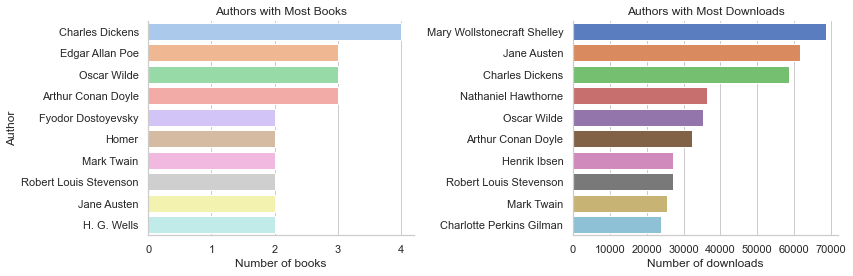

In [11]:
# Import seaborn
import seaborn as sns

# Set style of the plots and initialize figure
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# Get top 10 authors by the number of books in books_df
top_by_book_count = books_df['Author'].value_counts()[:10]
# Get top 10 authors by the number of downloads
top_by_download = books_df.groupby('Author')['Downloads'].sum().sort_values(ascending = False)[:10]

# Plot the authors with the most books
sns.barplot(ax=ax1,x=top_by_book_count.values, y=top_by_book_count.index, palette = 'pastel')
ax1.set_title('Authors with Most Books')
ax1.set_xlabel('Number of books')
ax1.set_ylabel('Author')

# Plot the authors with the most downloads
sns.barplot(ax=ax2,x=top_by_download.values, y=top_by_download.index, palette = 'muted')
ax2.set_title('Authors with Most Downloads')
ax2.set_xlabel('Number of downloads')
ax2.set_ylabel('')

plt.tight_layout()
sns.despine()

Let's also find out what are the 10 most used words in the titles of these books.

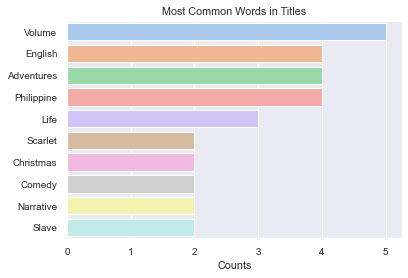

In [12]:
# We will use collections.Counter for counting, and we'll import stop words to filter out
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# Get a list of words used in the titles without punctuation
list_of_title_words = [x.strip(',').strip('.').strip(')').strip('(') 
                       for title in books_df['Title'] for x in title.split()]
# Keep words that are made up of only letters
list_of_title_words = [x for x in list_of_title_words if x.isalpha()]
# Filter out stop words
stopwords = ENGLISH_STOP_WORDS
list_of_title_words = [x for x in list_of_title_words if x.lower() not in stopwords]

# After examining the list, I noticed that words 'Philippine' and 'Philippines' both appear twice,
# but they don't make it into the word counter's 10 most common items. To fix that, I will change
# 'Philippine' to 'Philippines' in the list. Another way would be to run the list through a stemmer
list_of_title_words = ['Philippine' if x == 'Philippines' else x for x in list_of_title_words]

# Count the words
word_counter = Counter(list_of_title_words)

# Generate info for the plot from the counter's top 10 items
common_words = []
common_word_count = []
for common_word, count in word_counter.most_common(10):
    common_words.append(common_word)
    common_word_count.append(count)

# Plot the words
plt.figure(figsize = (6,4))
sns.set(font_scale = 0.9)
sns.barplot(x = common_word_count, y = common_words, palette = 'pastel')
plt.title('Most Common Words in Titles')
plt.xlabel('Counts');

Next, we will download the books from the website using the book index numbers in the DataFrame. The links are either  
```www.gutenberg.org/files/"book index"/"book index"-0.txt```  
or  
```www.gutenberg.org/files/"book index"/"book index".txt```  
So we'll need to check the beginning of the returned string to make sure we have the correct link, and then save the books locally as text files. To do that, we will create a function that will access the book link, extract the text, and save the text for future analysis  
(In regards to the links, we could go to each book's page and scrape the links from there, but as before, I'm trying to minimize the number of requests sent to the website.)

In [13]:
def get_book(book_index):
    # Create the URL
    url = f'https://www.gutenberg.org/files/{book_index}/{book_index}-0.txt'
    
    # Request the URL and set the encoding
    r = requests.get(url)
    r.encoding = 'utf-8'
    
    # Extract the text from the URL
    text = r.text
    
    # Check to make sure we have the correct data 
    # by checking if the returned text was from a 404 page
    # If it was, repeat the previous steps with a different link
    if text[:9] == '<!DOCTYPE':
        url = f'https://www.gutenberg.org/files/{book_index}/{book_index}.txt'
        r = requests.get(url)
        r.encoding = 'utf-8'
        text = r.text
    
    # Create book file name in 'datasets/Texts' as 'book index.txt'
    book_file_name = f'datasets/Texts/{book_index}.txt'
    
    # Save the file 
    with open(book_file_name,'w', encoding = 'utf-8') as book_file:
        book_file.write(text)
    
    return

Now we will iterate over the 'Book index' column and download each book.  
To make sure we don't send too many requests to the server too quickly, I will set up a sleep timer lasting between 1 and 5 seconds after every call to ```get_book```.

In [14]:
# Add a little counter to keep track of the current download number
current_number = 0
# Loop over 'Book index' column and download and save the books
for book in books_df['Book index']:
    current_number += 1
    print(f'Downloading book index {book:5}, #{current_number:2} of 97', end = '\r')
    get_book(book)
    time.sleep(random.randint(1,5))

Next step is to add the downloaded files to the ```books_df``` DataFrame in form of a ``` Book text``` column. We'll do that by looping over the ```index``` of ```books_df```, getting ```Book index``` values and using those values to read the files stored in ```'datasets/Texts'``` into the ```Book text``` column.

In [15]:
for index in books_df.index:
    # Set book_index variable by getting it from books_df
    book_index = books_df.loc[index,'Book index']
    # Use book_index to set file name of the book
    book_file_name = f'datasets/Texts/{book_index}.txt'
    
    # Read the file and append it to books_df
    with open(book_file_name,'r', encoding = 'utf-8') as book_file:
        books_df.loc[index, 'Book text'] = book_file.read()
        
books_df.head()

,Title,Author,Downloads,Book index,Book text
0,"Frankenstein; Or, The Modern Prometheus",Mary Wollstonecraft Shelley,68572,84,"﻿Project Gutenberg's Frankenstein, by Mary Wol..."
1,Pride and Prejudice,Jane Austen,52952,1342,﻿\n\nThe Project Gutenberg EBook of Pride and ...
2,The Scarlet Letter,Nathaniel Hawthorne,36468,25344,﻿The Project Gutenberg EBook of The Scarlet Le...
3,Et dukkehjem. English,Henrik Ibsen,27141,2542,﻿The Project Gutenberg EBook of A Doll’s House...
4,A Christmas Carol in Prose; Being a Ghost Stor...,Charles Dickens,25533,46,﻿The Project Gutenberg EBook of A Christmas Ca...


As we can see, the ```books_df``` is sorted by the number of downloads since that is how the data was scraped. To make future analysis easier, let's set the ```Book index``` column as the index.

In [16]:
# Check books_df index name so that we don't get an error if we re-run the cell
if books_df.index.name != 'Book index':
    # If the name is not 'Book index', set it to the 'Book index' column
    books_df.set_index('Book index', inplace = True)

books_df.head()

,Title,Author,Downloads,Book text
Book index,,,,
84,"Frankenstein; Or, The Modern Prometheus",Mary Wollstonecraft Shelley,68572,"﻿Project Gutenberg's Frankenstein, by Mary Wol..."
1342,Pride and Prejudice,Jane Austen,52952,﻿\n\nThe Project Gutenberg EBook of Pride and ...
25344,The Scarlet Letter,Nathaniel Hawthorne,36468,﻿The Project Gutenberg EBook of The Scarlet Le...
2542,Et dukkehjem. English,Henrik Ibsen,27141,﻿The Project Gutenberg EBook of A Doll’s House...
46,A Christmas Carol in Prose; Being a Ghost Stor...,Charles Dickens,25533,﻿The Project Gutenberg EBook of A Christmas Ca...


We'll perform a quick check to make sure the books loaded properly by checking maximum and minimum entry lengths in the ```Book text``` column, as well as indices of those entries. Let's also plot a histogram of book lengths.  
(This check helped me catch a couple of incorrectly downloaded files.)

Minimum length is 33232 which belongs to The Cask of Amontillado with book index 1063
Maximum length is 5561437 which belongs to A Dictionary of Cebuano Visayan with book index 40074


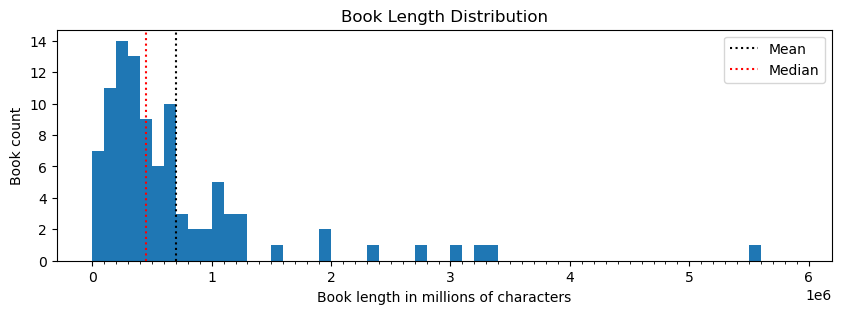

In [17]:
# Return to default style after fiddling with it earlier
plt.style.use('default')

# Get the minimum length and the index
min_length = min(books_df['Book text'].str.len())
min_length_id = books_df['Book text'].str.len().idxmin()
min_length_title = books_df.loc[min_length_id, 'Title']

# Get the maximum length and the index
max_length = max(books_df['Book text'].str.len())
max_length_id = books_df['Book text'].str.len().idxmax()
max_length_title = books_df.loc[max_length_id, 'Title']

# Print the minimum and maximum lengths and the related titles
print(f'Minimum length is {min_length} which belongs to {min_length_title} with book index {min_length_id}')
print(f'Maximum length is {max_length} which belongs to {max_length_title} with book index {max_length_id}')

# Display the histogram
bin_list = list(range(0, 6000000, 100000))
ax = books_df['Book text'].str.len().hist(grid = False, bins = bin_list, figsize = (10, 3))
ax.set_title('Book Length Distribution')
ax.set_xlabel('Book length in millions of characters')
ax.set_ylabel('Book count')
ax.set_xticks(list(range(0, 6000000, 100000)), minor = True)
# Plot a vertical line for mean number of characters
ax.axvline(books_df['Book text'].str.len().mean(), color = 'black', linestyle = 'dotted')
# Plot a vertical line for median number of characters
ax.axvline(books_df['Book text'].str.len().median(), color = 'red', linestyle = 'dotted')
plt.legend(['Mean', 'Median']);

(As the histogram shows, most of the books are less than 1.5 million characters in length. There's a considerable jump in length to the longest book. That's because it is a dictionary of the Cebuano language spoken in the Philippines, so it makes sense that it is a large text. It will be interesting to see what other books will be found to be similar to it.)  

Now that the data looks good, I can move on to the text analysis part.  
Before performing text preprocessing, I will generate a couple of word clouds to take a look at the most popular words in some of the more popular books (and because I think word clouds look cool). 

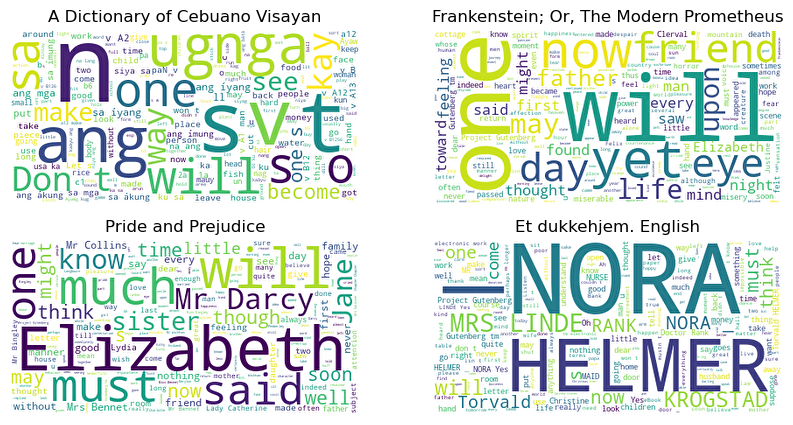

In [18]:
# Import wordcloud
import wordcloud

# Create a WordCloud object
cloud = wordcloud.WordCloud(background_color = 'white')

# Create figure and ax objects
fig, ax = plt.subplots(2,2, figsize = (10,5), dpi = 100)

# Create a list of books_df index values to loop over and generate the word clouds
# I'll use books 'A Dictionary of Cebuano Visayan', 'Frankenstein', 'Pride and Prejudice',
# and 'Et dukkehjem' because I'm interested in looking at them, but it can be done for any book
book_list = [40074, 84, 1342, 2542]

# I will loop over the ax object and book_list to generate the word clouds.
# However, since ax is 2x2 and book_list is 1x4, I will need another variable to access the 
# correct entry in book_list. I'll call it book_list_idx
book_list_idx = 0

for a in ax:
    for x in a:
        # Generate the cloud
        cloud.generate(books_df.loc[book_list[book_list_idx], 'Book text'])
        # Display the cloud
        x.imshow(cloud, interpolation="sinc")
        # Set the title of the cloud image to the title of the book
        x.set_title(books_df.loc[book_list[book_list_idx], 'Title'])
        # Remove the axis from the plot
        x.axis('off');
        # Increment book_list_idx to get the index of the next book
        book_list_idx += 1

That's interesting. The top tokens for 'A Dictionary of Cebuano Visayan' are not informative (they are abbreviations such as 'n' for 'noun', 'v' for 'verb', and 's.o.' and 's.t.' for 'someone' and 'something' respectively), and they will be removed. There are also a lot of tokens that don't resemble English words, and considering the rest of the corpus, I would expect this title to not have much similarity to other books.  

In regards to the other three titles, things seem pretty straightforward except that "Project Gutenberg" appears in a couple of places, and there's an odd line in the word cloud for 'Et dukkehjem', perhaps a chapter divider. We will be removing all non-alphabetic characters during pre-processing, so that should take care of the line, and we can consider adding 'project' and 'gutenberg' to the stop words list if we believe they are affecting the quality of the recommendations down the line.

Next step is to pre-process all the book texts. Thankfully, the function that tokenizes the strings for scikit-learn's ```CountVectorizer``` and ```TfidfVectorizer``` can take care of a lot of the steps.

In [19]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate Count Vectorizer with English stop words
count_vec = CountVectorizer(stop_words = 'english')

# Create the analyzer function from the CountVectorizer
analyzer = count_vec.build_analyzer()

# Check the results
print(analyzer("This is a sentence to check the analyzer.\
              And this is another one with s.o. and s.t. ABBREVS and lines ------\
              and numbers and punctuation for good measure 47 . !442 1 < *53 13.13\
              But does it stem the stems? Say says said don't. Also, rd R2-D2, s.t. s.o."))

['sentence', 'check', 'analyzer', 'abbrevs', 'lines', 'numbers', 'punctuation', 'good', 'measure', '47', '442', '53', '13', '13', 'does', 'stem', 'stems', 'say', 'says', 'said', 'don', 'rd', 'r2', 'd2']


As the example shows, ```analyzer``` took care of lowering the case, and removed punctuation, stop words, and single characters. It also tokenized everything! Nice!  

Now we just need to get rid of the numbers and stem the words. We will use NLTK's ```SnowballStemmer``` for the latter.  
To get all of that done in one shot, we will create a function called ```text_prep```.

In [20]:
# Import the SnowballStemmer
from nltk.stem.snowball import SnowballStemmer

# Create a SnowballStemmer for English
snowball = SnowballStemmer('english')

# Define the text_prep function
def text_prep(text):
    
    # Use analyzer to do the first few steps
    tokens = analyzer(text)
    
    # Remove tokens that aren't made up purely of letters of the alphabet
    # (Hopefully, there's nothing on Star Wars. Sorry, R2-D2. :/)
    pre_stem_tokens = [token for token in tokens if token.isalpha()]
    
    # Stem tokens for output
    output = [snowball.stem(token) for token in pre_stem_tokens]
    
    return output

# Let's try the text_prep function
print(text_prep("This is a sentence to check the analyzer.\
              And this is another one with s.o. and s.t. ABBREVS and lines ------\
              and numbers and punctuation for good measure 47 . !442 1 < *53 13.13\
              But does it stem the stems? Say says said don't. Also, rd R2-D2, s.t. s.o."))

['sentenc', 'check', 'analyz', 'abbrev', 'line', 'number', 'punctuat', 'good', 'measur', 'doe', 'stem', 'stem', 'say', 'say', 'said', 'don', 'rd']


Now we will need to reinitialize ```count_vec``` with ```tokenizer``` set to ```text_prep``` and use it to create a bag of words representation of each book. Let's set the ```max_df``` parameter to 0.95 to remove words that appear in almost every document as they will not be very informative, and ```min_df``` to 2 to keep tokens that appear in at least two documents in our corpus. We'll also set ```ngram_range``` to (1,3) to include bi and trigrams along with single tokens that match the document frequency.

In [21]:
count_vec = CountVectorizer(stop_words = 'english', tokenizer = text_prep,
                            max_df = 0.95, min_df = 2, ngram_range = (1,3))
count_vec_data = count_vec.fit_transform(books_df['Book text'])

I'll check out the number of words in the ```count_vec``` vocabulary and graph the top 15 tokens along with their frequencies.

Number of tokens in count_vec vocabulary: 550337


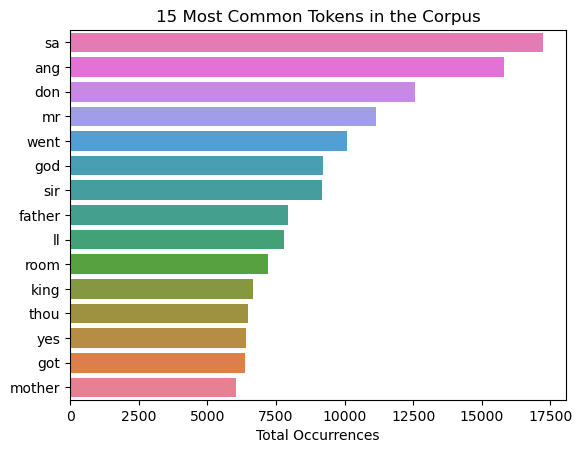

In [22]:
# Print the number of  words in the vocabulary
print(f'Number of tokens in count_vec vocabulary: {len(count_vec.vocabulary_)}')
# Import numpy
import numpy as np

# Calculate total token occurrences by adding the rows of the count_vec_data
# so we end up with (1 x Number of features) array where entries are the total
# number of times the token corresponding to the column appeared in the corpus
frequency_sums = np.asarray(count_vec_data.sum(axis = 0))
# Get the count_vec feature names (just in case the function name wasn't clear)
count_vec_tokens = count_vec.get_feature_names()
   
# Match the features to their frequencies
token_count = zip(count_vec_tokens, frequency_sums[0])
# Sort the zip object by the values of the second item of each tuple, the number of occurrences,
# in reverse order, from largest to smallest, and grab the first 15
token_count = sorted(token_count, key=lambda x:x[1], reverse=True)[:15]
# Set top_tokens to the first element of each tuple, the feature
top_tokens = [t[0] for t in token_count]
# Set counts to the second element of each tuple, the occurences
counts = [t[1] for t in token_count]

# Plot the words and their counts
colors = reversed(sns.color_palette('husl', 15))
sns.barplot(x = counts, y = top_tokens, palette = colors)
plt.xlabel('Total Occurrences')
plt.title('15 Most Common Tokens in the Corpus')
plt.show()

There are a few tokens in the above plot that probably could have been removed during pre-processing. 'sa' is a preposition in the Cebuano language, 'ang' is its equivalent to 'the' in English, 'don' is a stemmed version of "don't" (but it could also be a title like in 'Don Quixote'), 'll' is a contraction of 'will' or 'shall'. We can add them to the list of stop words and re-run the ```count_vec```. I will discuss tokenization more at the end of the project.

In the next step, we will create a TF-IDF representation of each text. We will then use it along with cosine similarity to deliver recommendations.  
To get the TF-DF representations, we will use a ```TfidfTransformer``` on the ```count_vec_data``` matrix we got earlier.

In [23]:
# Import TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize a TF-IDF transformer and get TF-IDF representations of count_vec_data
tfidf_transformer = TfidfTransformer()
tfidf_representations = tfidf_transformer.fit_transform(count_vec_data)

To calculate cosine similarity, we can use one of the functions in scikit-learn. Since scikit-learn normalizes the TF-IDF vectors, using ```cosine_similarity``` or ```linear_kernel``` produces the same results with the <a href=https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity>second method being faster</a>. We will then convert the resulting matrix into a DataFrame with ```Book index``` for rows and columns to look for similar books.

In [24]:
# Import linear_kernel and calculate cosine similarity of the tfidf_representations
from sklearn.metrics.pairwise import linear_kernel

similarity_scores = linear_kernel(tfidf_representations)

# Create the DataFrame and display the top few rows
similarity_scores_df = pd.DataFrame(similarity_scores,
                                    index = books_df.index, columns = books_df.index)
similarity_scores_df.head()

Book index,84,1342,25344,2542,46,1952,11,41,1080,1250,...,4517,376,35,1063,1251,766,35899,1998,815,13701
Book index,,,,,,,,,,,,,,,,,,,,,
84,1.000000,0.229625,0.148749,0.022958,0.165811,0.074023,0.050048,0.109915,0.090226,0.118710,...,0.100837,0.160145,0.169354,0.030025,0.041280,0.163329,0.109496,0.110103,0.174716,0.089992
1342,0.229625,1.000000,0.063660,0.035037,0.104801,0.047845,0.030217,0.038034,0.042551,0.035181,...,0.051104,0.080268,0.053951,0.013455,0.030673,0.248958,0.039545,0.027028,0.068139,0.034068
25344,0.148749,0.063660,1.000000,0.010908,0.085031,0.037486,0.020939,0.062460,0.043520,0.066782,...,0.049829,0.076933,0.082947,0.013716,0.043833,0.097168,0.060345,0.125049,0.090256,0.058096
2542,0.022958,0.035037,0.010908,1.000000,0.038411,0.020931,0.011166,0.008042,0.010513,0.012152,...,0.021645,0.014915,0.016682,0.003972,0.002639,0.046650,0.007684,0.006081,0.009439,0.008151
46,0.165811,0.104801,0.085031,0.038411,1.000000,0.092270,0.059961,0.106435,0.049795,0.097131,...,0.108469,0.115864,0.133881,0.031121,0.035173,0.188243,0.054123,0.063664,0.060093,0.042799


The reason I chose to combine a ```CountVectorizer``` and a ```TfidfTransformer``` instead of just calling a ```TfidfVectorizer``` to get the matrix (result would have been the same) is so that we can use the ```count_vec_data``` in latent Dirichlet allocation (LDA) to infer possible topics that are in the corpus and each document, and then use that information to widen our recommendations (and obviously, we needed ```count_vec_data``` to make the pretty chart of the top 15 tokens earlier). So, let's do that now.  

First, we'll need to decide on how many topics to use. To figure that out, I will fit an LDA model for topic number values of 5, 10, 15, 20, 25, 30, and 35, collect and plot their final perplexity scores, and look for the "elbow" in the plot. We want the lowest perplexity score for the lowest number of topics.

In [32]:
# Import the module
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Initialize an empty list to hold the scores
perplexity_bounds = []
# Initialize a list of values to use as the number of topics
number_of_topics = list(range(5, 36, 5))

# Loop over the numbers of topics, initialize a model with that number, fit it to the data,
# and append the final score to perplexity_bounds
for number in number_of_topics:
    lda = LDA(n_components=number)
    lda.fit(count_vec_data)
    perplexity_bounds.append(lda.bound_)

Let's check out the results by plotting them and looking for the "elbow".

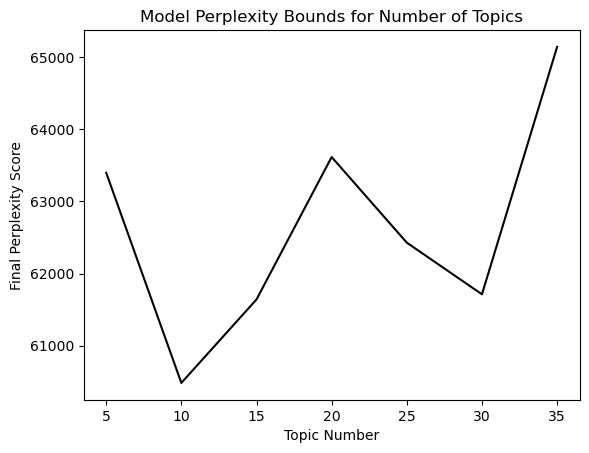

In [33]:
sns.lineplot(x = number_of_topics, y = perplexity_bounds, color = 'black')
plt.title('Model Perplexity Bounds for Number of Topics')
plt.xlabel('Topic Number')
plt.ylabel('Final Perplexity Score');

There's no real "elbow", but there is a noticeable dip at 10 topics, so we will use that number for our LDA model. (I will discuss this and other aspects of using LDA a bit more at the very end.) We will now transform the ```count_vec_data``` using LDA and create a document/topic DataFrame which we can use to make topic-based recommendations.

In [34]:
# Initialize the model and apply it to count_vec_data
lda = LDA(n_components=10)
lda_matrix = lda.fit_transform(count_vec_data)

# Create column names for topic_df
topic_df_columns = [f'Topic {x}' for x in range(10)]
# Create the DataFrame and show the top rows
topic_df = pd.DataFrame(lda_matrix, index = books_df.index, columns = topic_df_columns)
topic_df.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Book index,,,,,,,,,,
84,0.000003,0.000003,0.000003,0.000003,0.000003,0.759102,0.240877,0.000003,0.000003,0.000003
1342,0.000002,0.000002,0.000002,0.000002,0.000002,0.999984,0.000002,0.000002,0.000002,0.000002
25344,0.049164,0.000002,0.000002,0.041812,0.000002,0.000002,0.909008,0.000002,0.000002,0.000002
2542,0.000008,0.000008,0.355508,0.408051,0.035942,0.200449,0.000008,0.000008,0.000008,0.000008
46,0.000007,0.000007,0.000007,0.999939,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007


We can check out what the topics for our model are. (Because the topics are based on frequency of token occurrence, they might not make semantic sense.) Let's use top 10 tokens for each topic. A thing to note is that since we used bi and trigrams during tokenization, a single token can contain up to three words.

In [35]:
# We already defined the variable 'count_vec_tokens = count_vec.get_feature_names()' in section 19
# Create tuples of topic number and associated component and loop over them
for topic_x, topic in enumerate(lda.components_):
    # Print the topic number and tokens of count_vec_tokens that are associated
    # with the top frequencies for each LDA component
    print(f'Topic {topic_x}:'," ".join([count_vec_tokens[i] for i in topic.argsort()[:-10 - 1:-1]]))

Topic 0: went father room marius jean mother hour chapter cri woman
Topic 1: count ann cristo mont yes oh albert morrel valentin repli
Topic 2: sa ang ka nga kay ku na dì lang pa
Topic 3: mr don ll went got boy father mrs cri yes
Topic 4: don went princ room ll pierr mari began mr yes
Topic 5: mr don quixot don quixot sancho miss mrs ladi sir quit
Topic 6: god soul tis present opinion truth king desir human son
Topic 7: god thou thi thee king common heaven hath war son
Topic 8: et thou zarathustra ye la li lo king island ms
Topic 9: sir knight king ye whale ship tristram sir tristram chapter arthur


Now, let's get our recommendations! This is how we will do it:
1. Get a book index to use as the base for the recommendations
2. For that base, find top 5 cosine similarity scores (not including its own) and related book indices
3. Find the primary topic of the base and find top 5 documents for that topic (not including the base) and get their book indices
4. Return the titles and authors of the books  

To make it all happen, we will create a function called ```get_recommendations``` that takes in a book index and returns the recommendations. We will print recommendation titles and authors by creating a function called ```return_recommendations```. (Because it is possible that for a given book, the books with top cosine similarity scores and top books for the topic are the same (so we're getting the same 5 books based on cosine similarity and topic), the number of returned recommendations will be at least 5 and at most 10.)

In [36]:
def get_recommendations(book):
    # Get book index numbers at indices 1 through 5 of sorted similarity scores for the base
    # We skip index 0 because it's the base book itself
    recs_by_cosine = similarity_scores_df[book].sort_values(ascending = False)[1:6].index.to_list()
    
    # Find the primary topic for the base
    primary_topic = topic_df.loc[book].idxmax()
    # Get book index numbers for the top 5 books in the base's primary topic
    recs_by_topic = topic_df[primary_topic].sort_values(ascending = False)[0:5].index.to_list()
    
    # Check recs_by_topic for the base book so that it doesn't get returned as a recommendation
    recs_by_topic = [x for x in recs_by_topic if x != book]
    
    # Create the list of recommended books by combining recs_by_cosine and books
    # from recs_by_topic that are not in recs_by_cosine
    recs_list = recs_by_cosine + [x for x in recs_by_topic if x not in recs_by_cosine]
    
    return recs_list

def return_recommendations(book):
    print(f'Recommendations for "{books_df.loc[book,"Title"]}" by {books_df.loc[book,"Author"]}:\n')
    # Get a list of recommendations by calling get_recommendations and print the related titles
    for book_index in get_recommendations(book):
        print(f'"{books_df.loc[book_index,"Title"]}" by {books_df.loc[book_index,"Author"]}')
    print('\n')
    
    return

Let's check out recommendations for a few of the books.

In [37]:
return_recommendations(84)
return_recommendations(1063)
return_recommendations(40074)
return_recommendations(38269)

Recommendations for "Frankenstein; Or, The Modern Prometheus" by Mary Wollstonecraft Shelley:

"The Works of Edgar Allan Poe — Volume 2" by Edgar Allan Poe
"Essays of Michel de Montaigne — Complete" by Michel de Montaigne
"Walden, and On The Duty Of Civil Disobedience" by Henry David Thoreau
"The Republic" by Plato
"Jane Eyre: An Autobiography" by Charlotte Brontë
"Emma" by Jane Austen
"Pride and Prejudice" by Jane Austen
"The Importance of Being Earnest: A Trivial Comedy for Serious People" by Oscar Wilde
"The Hound of the Baskervilles" by Arthur Conan Doyle
"Great Expectations" by Charles Dickens


Recommendations for "The Cask of Amontillado" by Edgar Allan Poe:

"The Works of Edgar Allan Poe — Volume 2" by Edgar Allan Poe
"The Masque of the Red Death" by Edgar Allan Poe
"Wuthering Heights" by Emily Brontë
"The Republic" by Plato
"Les Misérables" by Victor Hugo
"War and Peace" by graf Leo Tolstoy
"Uncle Tom's Cabin" by Harriet Beecher Stowe
"Prestuplenie i nakazanie. English" by Fyo

I think those look pretty good! Especially if we consider how small the corpus was. It's also good to see that the top recommendation for a dictionary is the only other dictionary in the corpus (I checked).

It would also be nice to get recommendations for a book that is not in the corpus. So, let's make a function for that. It will take a book index number which matches its filename, open the file, process the text using the tools we've built and make the recommendations based on that.

In [38]:
def new_book_recommendations(book):
    # Use the passed argument to set the file name
    book_file_name = f'datasets/Texts/{book}.txt'
    
    # Read the file and assign the text to a variable for analysis
    with open(book_file_name,'r', encoding = 'utf-8') as book_file:
        text = book_file.read()
        
    # Transform text using count_vec into a count vector
    text = count_vec.transform([text])
    
    # Get the TF-IDF representation and topic distribution based on the previously fitted data
    text_tfidf = tfidf_transformer.transform(text)
    text_lda = lda.transform(text)
    
    # Calculate cosine similarities to the books in the corpus
    text_cosine_scores = linear_kernel(tfidf_representations, text_tfidf)
    # Extract the indices of the 5 books with highest cosine similarity 
    text_cosine_rec_iloc_idx = text_cosine_scores.reshape(-1).argsort()[:-6:-1]
    # Get the book index values
    recs_by_cosine = [books_df.iloc[idx].name for idx in text_cosine_rec_iloc_idx]
    
    # Get the top topic for the document and recommendations based on that
    text_topic = text_lda.argmax()
    recs_by_topic = topic_df[f'Topic {text_topic}'].sort_values(ascending = False)[0:5].index.to_list()
    
    # Combine the recommendations lists and remove any possible duplicates
    recs_list = recs_by_cosine + [x for x in recs_by_topic if x not in recs_by_cosine]
    
    # Print out recommended titles and their authors
    print(f'Recommendations for book index {book}:\n')
    for book_index in recs_list:
        print(f'"{books_df.loc[book_index,"Title"]}" by {books_df.loc[book_index,"Author"]}')
    print('\n')
    
    return

Let's test the function on a few book files that I downloaded: "Gulliver's Travels into Several Remote Nations of the World" by Jonathan Swift (book index 829), "The Devil's Dictionary" by Ambrose Bierce (972), and "Anna Karenina" by graf Leo Tolstoy (1399)

In [39]:
new_book_recommendations(829)
new_book_recommendations(972)
new_book_recommendations(1399)

Recommendations for book index 829:

"Essays of Michel de Montaigne — Complete" by Michel de Montaigne
"The Interesting Narrative of the Life of Olaudah Equiano, Or Gustavus Vassa, The African" by Olaudah Equiano
"The Works of Edgar Allan Poe — Volume 2" by Edgar Allan Poe
"Autobiography of Benjamin Franklin" by Benjamin Franklin
"Walden, and On The Duty Of Civil Disobedience" by Henry David Thoreau
"The Republic" by Plato
"The Odyssey" by Homer
"Beyond Good and Evil" by Friedrich Wilhelm Nietzsche
"The Kama Sutra of Vatsyayana" by Vatsyayana


Recommendations for book index 972:

"Essays of Michel de Montaigne — Complete" by Michel de Montaigne
"The Republic" by Plato
"The Works of Edgar Allan Poe — Volume 2" by Edgar Allan Poe
"Beyond Good and Evil" by Friedrich Wilhelm Nietzsche
"Walden, and On The Duty Of Civil Disobedience" by Henry David Thoreau
"The Odyssey" by Homer
"The Kama Sutra of Vatsyayana" by Vatsyayana


Recommendations for book index 1399:

"The Brothers Karamazov" by 

The last thing I want to do is to cluster books together based on their cosine similarities and create a dendrogram to have a visual representation. We didn't use clustering in recommendations, but I want to mention it in the closing comments.

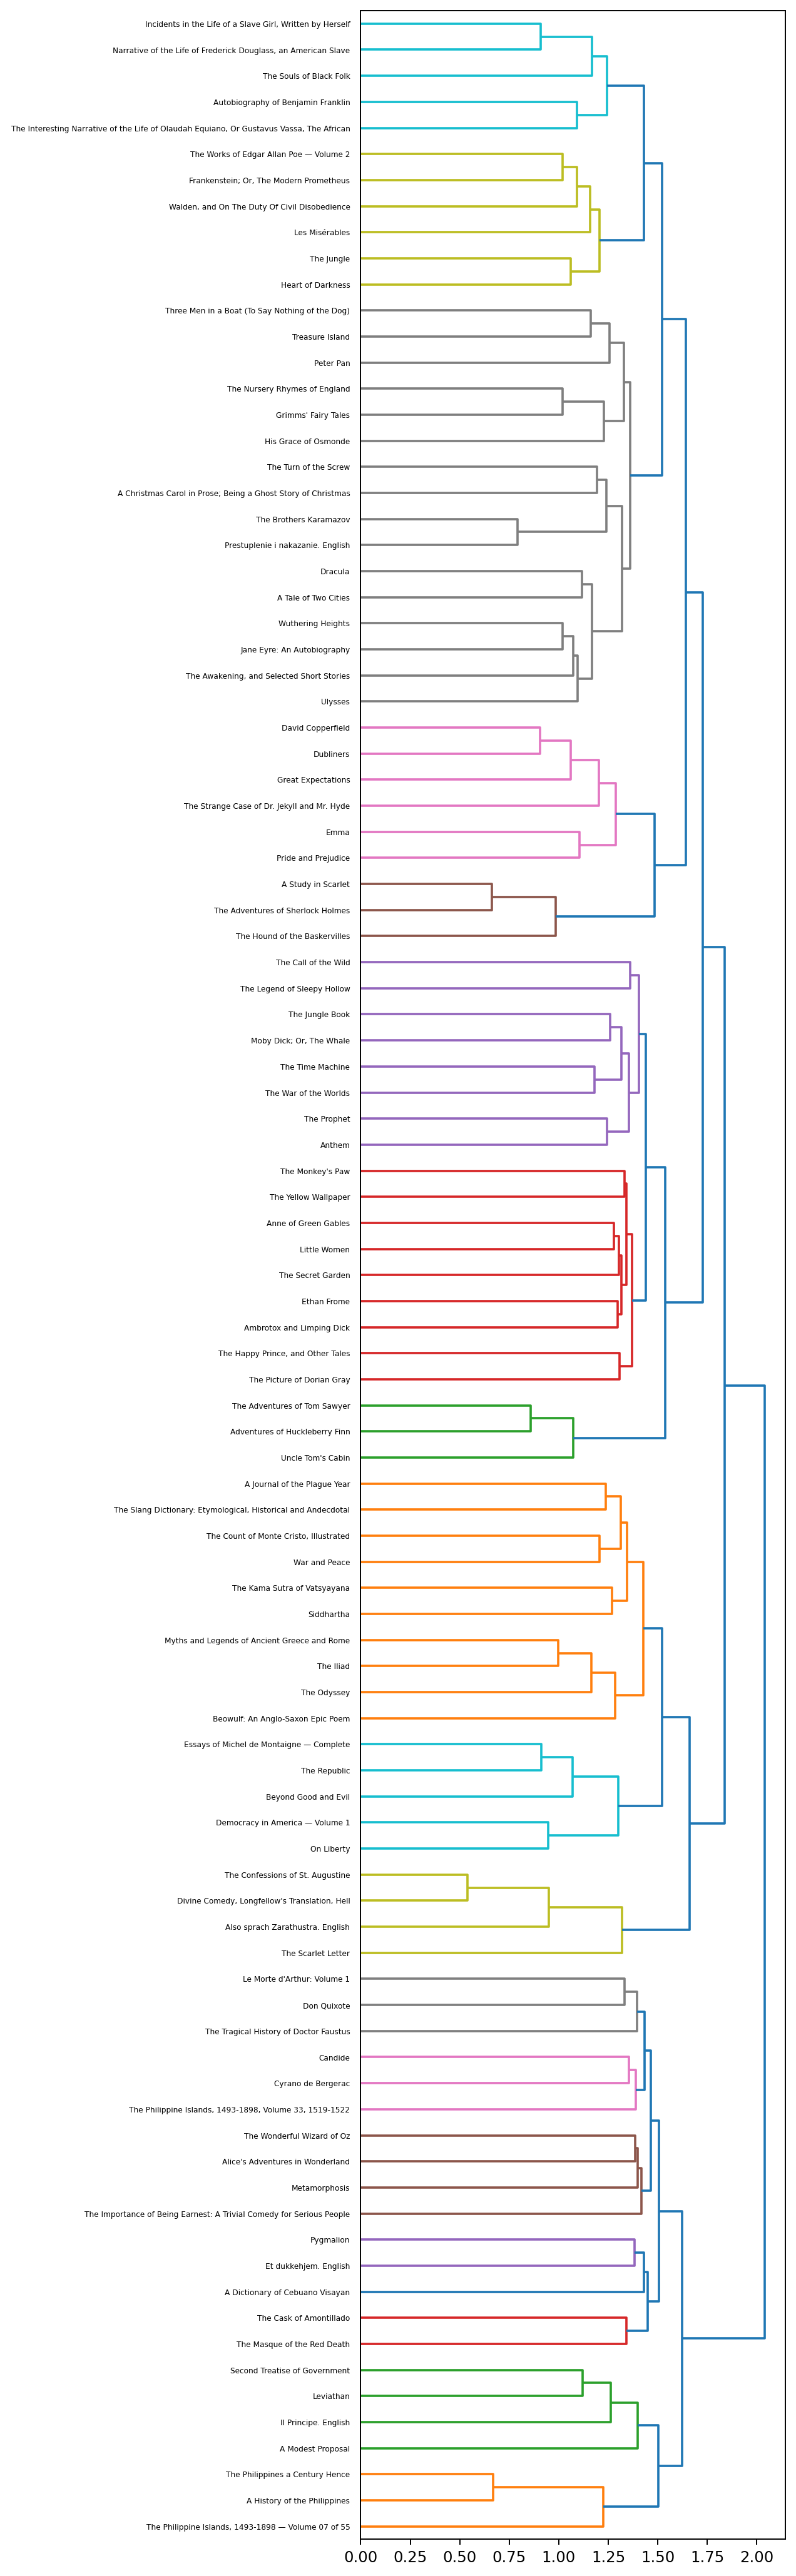

In [40]:
# Make the necessary import
from scipy.cluster import hierarchy

# Calculate cosine distances to use for cluster computations
cosine_distances = 1 - similarity_scores
# Compute the clusters from the similarity matrix,
linkage = hierarchy.linkage(cosine_distances, 'complete')
# Set figure size to be able to see things clearly
plt.figure(figsize = (5, 30), dpi = 175);
# Display the dendogram
hierarchy.dendrogram(linkage, labels = [title for title in books_df['Title']], orientation = 'right');

## Summary and further discussion

The purpose of this project was to create a content-based book recommendation system that would make suggestions based on the item being viewed. The goal of the system is to keep the user engaged with the service, therefore increasing the value of the service. The system returns recommendations based on TF-IDF similarity of other books to the base as well as texts from the same topic assigned by the LDA model. In deployment, the recommendations would be shown on the webpage of the base item. As an example, someone who views Mary Shelley's "Frankenstein" would see "The Works of Edgar Allan Poe — Volume 2" by Edgar Allan Poe and other titles returned by the system under the heading "Check out similar works".

#### Possible improvements
###### Collaborative filtering
The system in this project is a content-based system, so it recommends books by analyzing the contents of each one and finding books that are similar. Another approach would be collaborative filtering, where the system compares **user** preferences instead and finds **users** that are similar. As a simple example, let's say Alex liked books {A, B, C, D}, Ben liked books {A, B, C}, and Charlie liked books {B, C, D}. Based on their similarities to Alex, Ben would be recommended book D, and Charlie would be recommended book A. To implement this approach, we would need to store and dynamically update user preferences to calculate their similarities. If we wanted to take things a step further, a combination of content-based and collaborative filtering approaches could be more effective than either one alone.
###### Modifying implemented models and approaches
To build this system, I analyzed only about 100 books. The number of books available through Project Gutenberg is 63,904. That is a big difference. And while the approach taken here could be used directly if we have enough resources, we could make some modifications to reduce data dimensionality and related overhead while ensuring quality results.
1. **Extra information:** An important constraint that I imposed on myself while working on this project was to keep the number of requests sent to the server to a minimum and to only use the information available in the HTML code of the four locally saved webpages. If that wasn't the case, it would be possible to scrape the webpage of each book for metadata such as language, subject, and Library of Congress classification (LoC Class), all of which could be helpful in subsetting the books to provide better recommendations.
2. **Languages:** Books in different languages would need to be pre-processed, vectorized, and compared separately, which would result in separate computations and data structures for each language.
3. **Tokenization:** To speed up processing of a large number of texts while maintaining recommendation quality, it could be helpful to explore different tokenization parameters. After fitting the count vectorizer used in this project to the data with parameters {max_df = 0.95, min_df = 2, ngram_range = (1,3)} and keeping minimum token length to 2 characters, the size of the returned vocabulary was 550,338 tokens. For comparison, the size of the vocabulary of a vectorizer fitted to the same data with the same minimum token length but without setting max_df, min_df, and leaving ngram_range at (1,1) is 128,579. Higher order n-grams definitely add a lot of dimensionality, but they can also help find significant similarity. One of possible approaches to try out could be to use a more aggressive tokenizer, perhaps one that keeps only tokens that appear in a relatively small fraction of the documents by setting max_df to a lower value or one that only keeps bigrams and trigrams. Another way to reduce dimensionality during tokenization could be to add more items to the list of stop words, but that might not be necessary if max_df is set low enough.
4. **LDA model and clustering:** The application of latent Dirichlet allocation in this project was more academic than practical. It provided the benefit of expanding the recommendation range by classifying the books. However, if we have the subject and Loc Class metadata of each book, that task is already complete, and additional recommendations can be made based on those two categories. If we want to widen the recommendations further, we could also cluster books together through hierarchical or k-means clustering, and recommend other titles from the same cluster along with subject and cosine similarity-based recommendations. The goal would be to find a balance and provide enough reading options for the user to stay engaged without causing choice overload.  
(A note on the perplexity bounds graph: its "jumpiness" is most likely due to the inclusion of bi and tri-grams in the countvectorizer. If we re-run the LDA model on a vectorizer consisting only of unigrams, that graph should be monotonically decreasing.)
5. **Data structure:** To reduce resource usage, processed data can be broken down into several DataFrames or NumPy arrays with exact implementation contingent on the resource restrictions.

Here is the summary of the steps taken in the project:
- Load the HTML from the saved pages
- Build a scraping function and collect the title, author, number of downloads, and book index information
- Load the scraped data into a DataFrame and remove duplicates and titles that are not in English
- Perform visual exploratory data analysis
- Build a function to download the book texts and append them to the DataFrame 
- Display a histogram of book lengths and create word clouds of a few of the texts
- Build a tokenizer function, create frequency count vectors of the texts, and display top 15 tokens
- Create TF-IDF vectors of the books, calculate their similarities, and load the similarity scores into a DataFrame
- Create an LDA model, fit it to the texts, and create a DataFrame with topic probabilities for each book
- Build recommendation functions for books within and outside the corpus
- Cluster texts and create a dendrogram
- Summarize the goal of the project and provide possible improvements and a scaling strategy